In [2]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000


In [6]:
sentences = []
labels = []
urls = []

with open("sarcasm_Headlines_Dataset.json", 'r') as f:
    for line in f:
        item = json.loads(line)
        sentences.append(item['headline'])
        labels.append(item['is_sarcastic'])
        urls.append(item['article_link'])

# Check the loaded data
print(f"Total headlines: {len(sentences)}")
print(f"Total labels: {len(labels)}")
print(f"Total URLs: {len(urls)}")


Total headlines: 26709
Total labels: 26709
Total URLs: 26709


In [8]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [10]:
#initialize the tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
#fit the tokenizer on the texts
tokenizer.fit_on_texts(training_sentences)
#get the word index dictionary
word_index = tokenizer.word_index

print("First 10 items in the word_index dictionary:")
for i, (word, index) in enumerate(word_index.items()):
    if i < 10:
        print(f"{word}: {index}")
    else:
        break

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

First 10 items in the word_index dictionary:
<OOV>: 1
to: 2
of: 3
the: 4
in: 5
for: 6
a: 7
on: 8
and: 9
with: 10


In [12]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)
                        

In [14]:
#model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [20]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (32, 100, 16)          │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (32, 16)               │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 24)               │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 1)                │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 481,301 (1.84 MB)

 Trainable params: 160,433 (626.69 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 320,868 (1.22 MB)

In [24]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 1s - 1ms/step - accuracy: 0.5768 - loss: 0.6750 - val_accuracy: 0.5755 - val_loss: 0.6319
Epoch 2/30
625/625 - 1s - 918us/step - accuracy: 0.7520 - loss: 0.5144 - val_accuracy: 0.7846 - val_loss: 0.4551
Epoch 3/30
625/625 - 1s - 905us/step - accuracy: 0.8291 - loss: 0.3878 - val_accuracy: 0.8392 - val_loss: 0.3856
Epoch 4/30
625/625 - 1s - 900us/step - accuracy: 0.8536 - loss: 0.3408 - val_accuracy: 0.8182 - val_loss: 0.3934
Epoch 5/30
625/625 - 1s - 890us/step - accuracy: 0.8735 - loss: 0.3007 - val_accuracy: 0.8508 - val_loss: 0.3561
Epoch 6/30
625/625 - 1s - 906us/step - accuracy: 0.8907 - loss: 0.2710 - val_accuracy: 0.8041 - val_loss: 0.4286
Epoch 7/30
625/625 - 1s - 901us/step - accuracy: 0.9008 - loss: 0.2462 - val_accuracy: 0.8527 - val_loss: 0.3496
Epoch 8/30
625/625 - 1s - 913us/step - accuracy: 0.9060 - loss: 0.2319 - val_accuracy: 0.8545 - val_loss: 0.3482
Epoch 9/30
625/625 - 1s - 910us/step - accuracy: 0.9116 - loss: 0.2203 - val_accuracy: 0.8290 - va

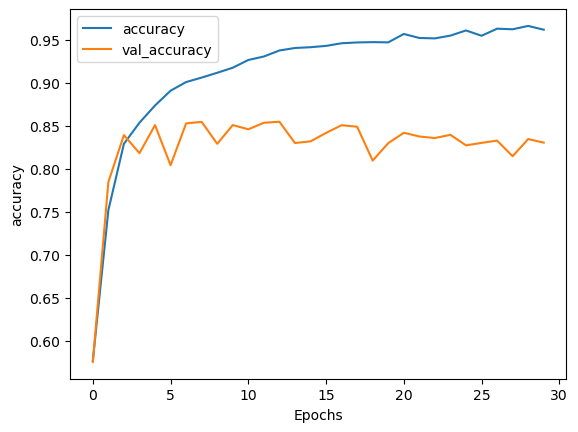

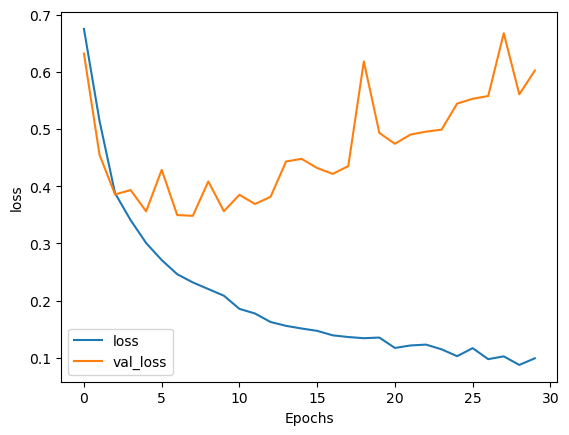

In [28]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [30]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [32]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [34]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [46]:
sentence = ["Granny was walking her dog when she stepped onto a pile of dog poop.", "She always takes the time to help others without expecting anything in return."]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

predictions = model.predict(padded)

for i, prediction in enumerate(predictions):
    print(f"Sentence {i+1}: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Sentence 1: [0.11633992]
Sentence 2: [0.00616715]
